<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

## 3. Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings("ignore")

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from tqdm import tqdm

### 3.1 Loading dataset and basic stats

In [2]:
df = pd.read_csv("train.csv")
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


We are given a minimal number of data fields here, consisting of:

* id: Looks like a simple rowID
* qid{1, 2}: The unique ID of each question in the pair
* question{1, 2}: The actual textual contents of the questions.
* is_duplicate: The label that we are trying to predict - whether the two questions are duplicates of each other.

In [3]:
print("Number of data points:",df.shape[0])

Number of data points: 404290


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


* Looks like there are 2 null values in question2 column and 1 in question1, let's check and remove them.

### 3.2 Removing Null Values

In [5]:
print("Before removing null values: ", df.shape[0])
df.dropna( inplace = True)
print("After removing null values: ", df.shape[0])

Before removing null values:  404290
After removing null values:  404287


* All 3 null value rows has been removed.

### 3.2 Class Imbalance

<AxesSubplot:xlabel='is_duplicate', ylabel='count'>

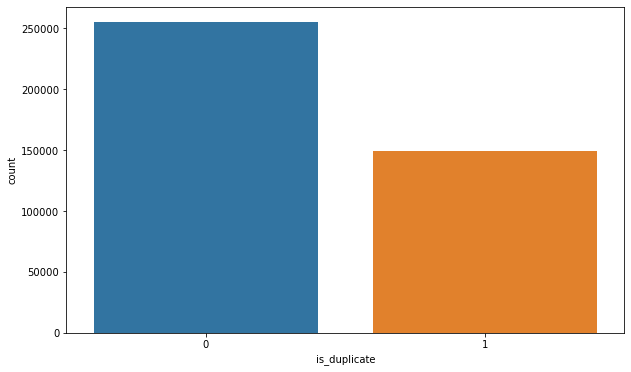

In [6]:
plt.figure(figsize=(10, 6))
sns.countplot(x ='is_duplicate', data = df)

In [7]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


* We have 36.92% positive class data, and 63.08% negative class data, hence our dataset is imbalance.

### 3.3 Repeated questions

### 3.3.1 Percentage of repeated questions

Total number of unique questions:  537929
Total number of repeated questions: 111778 (20.78%)



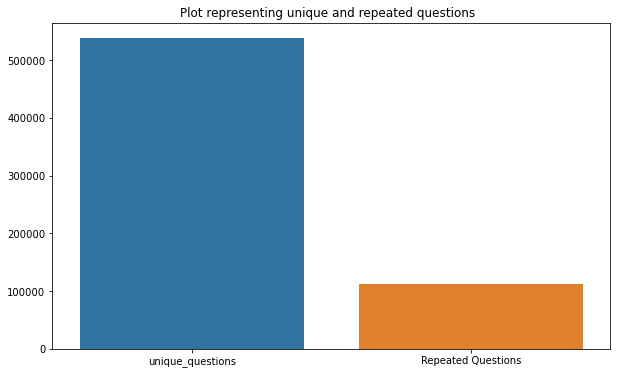

In [8]:
# Number of Repeated Questions
qids = pd.Series(df['qid1'].tolist()+df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_multiple_occurances = np.sum(qids.value_counts() > 1)

print("Total number of unique questions: ", unique_qs)
print("Total number of repeated questions: {} ({}%)\n".format(qs_multiple_occurances, round(qs_multiple_occurances/unique_qs*100,2)))

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_multiple_occurances]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

### 3.3.2 Number of occurances of each question

Maximum number of times a single question is repeated: 157



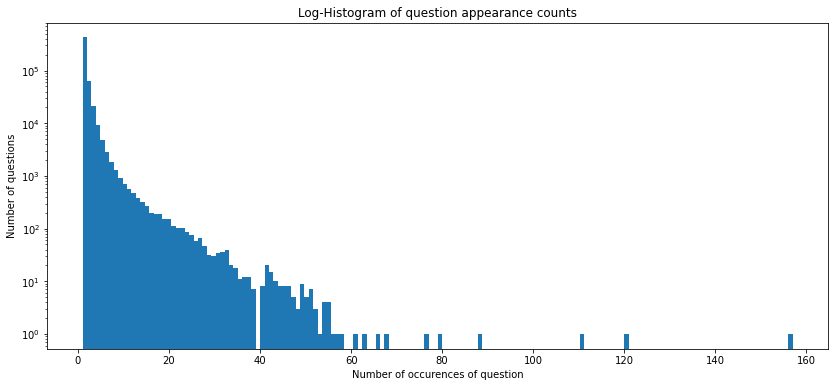

In [9]:
plt.figure(figsize=(14, 6))
plt.hist(qids.value_counts(), bins=160)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

### 3.3.2 Checking for Duplicates

In [10]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count()
print ("Number of duplicate questions:", df.shape[0] - (pair_duplicates).shape[0])

Number of duplicate questions: 0


### 3.4 EDA Observations

* 17.2 % of the questions are repeated more than once.
* Maximum number of times a question has been repeated: 157.
* Here, we will not remove the repeated questions as it adds value to the entire data.
* For example - on question has been repeated 157 times, which means keywords in that question shows that there is possibility of questions with those keywords being asked again and again, they should be given more weightage.
* No duplicate(repeated pair of questions) data is present in the dataset.

## 4. Splitting data

In [11]:
y_true = df['is_duplicate'].values
df.drop('is_duplicate', axis=1, inplace=True)
df.reset_index(inplace=True)

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.3)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.3)

In [12]:
X_train.head()

,index,id,qid1,qid2,question1,question2
333093,333095,333095,7495,128155,Which are some of the best romantic movies?,What are the best romantic movies?
148091,148092,148092,28196,84951,How do I stop my Pomeranian/Shih Tzu mix from ...,How do I stop my Australian Shepherd/Border Co...
198063,198064,198064,93240,123036,Is WWE Really fake?,Is fighting in wwe real or fake?
365860,365863,365863,47461,153209,What hotel in Kolkata would be safe for unmarr...,What hotel in Jhansi would be safe for unmarri...
166495,166496,166496,35129,258335,How do I stop wasting my time? Could that be p...,How can I make better use of my time?


## 5 Basic Feature Extraction

### 5.1 Extracting basic features

Constructing 13 features mentioned below:
* **len_q1** : Length of question 1
* **len_q2** : Length of question 2
* **freq_q1** : Frequency of question 1
* **freq_q2** : Frequency of question 2
* **num_w_q1** : Number of words in question 1
* **num_w_q2** : Number of words in question 2
* **word_common** : Number of common words in question 1 & 2
* **word_total** : Sum of total number of words in question 1 & 2
* **word_share** : (num_common_w/sum_total_w)
* **freq_sum & freq_diff** 
* **len_sum & len_diff**

In [13]:
df.head()

,index,id,qid1,qid2,question1,question2
0,0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...
2,2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...
3,3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...
4,4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?


In [14]:
for dfx in tqdm([X_train, X_test, X_cv]):
    # Length Features
    dfx['len_q1'] = dfx['question1'].str.len()
    dfx['len_q2'] = dfx['question2'].str.len()
    dfx['len_sum'] = dfx['len_q1'] + dfx['len_q2']
    dfx['len_diff'] = abs(dfx['len_q1'] - dfx['len_q2'])

    # Frequency Features
    dfx['freq_q1'] = dfx.groupby('question1')['question1'].transform('size')
    dfx['freq_q2'] = dfx.groupby('question2')['question2'].transform('size')
    dfx['freq_sum'] = dfx['freq_q1'] + dfx['freq_q2']
    dfx['freq_diff'] = abs(dfx['freq_q1'] - dfx['freq_q2'])
    
    # Number of words features
    dfx['num_w_q1'] = dfx['question1'].map( lambda x: len(x.split(" ")))
    dfx['num_w_q2'] = dfx['question2'].map( lambda x: len(x.split(" ")))
    
    def normalized_word_common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return len(w1 & w2)
    dfx['word_common'] = dfx.apply(normalized_word_common, axis=1)
    
    def normalized_word_total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return len(w1) + len(w2)
    dfx['word_total'] = df.apply(normalized_word_total, axis=1)
    
    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return len(w1 & w2)/(len(w1) + len(w2))
    dfx['word_share'] = df.apply(normalized_word_share, axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:19<00:00, 26.38s/it]


In [15]:
X_train.head()

,index,id,qid1,qid2,question1,question2,len_q1,len_q2,len_sum,len_diff,freq_q1,freq_q2,freq_sum,freq_diff,num_w_q1,num_w_q2,word_common,word_total,word_share
333093,333095,333095,7495,128155,Which are some of the best romantic movies?,What are the best romantic movies?,43,34,77,9,4,4,8,0,8,6,5,14,0.357143
148091,148092,148092,28196,84951,How do I stop my Pomeranian/Shih Tzu mix from ...,How do I stop my Australian Shepherd/Border Co...,67,81,148,14,4,7,11,3,12,13,9,23,0.391304
198063,198064,198064,93240,123036,Is WWE Really fake?,Is fighting in wwe real or fake?,19,32,51,13,5,3,8,2,4,7,3,11,0.272727
365860,365863,365863,47461,153209,What hotel in Kolkata would be safe for unmarr...,What hotel in Jhansi would be safe for unmarri...,123,122,245,1,3,1,4,2,20,20,18,38,0.473684
166495,166496,166496,35129,258335,How do I stop wasting my time? Could that be p...,How can I make better use of my time?,54,37,91,17,2,2,4,0,11,9,4,20,0.200000


### 5.2 Analysis of extracted features

In [16]:
print ("Minimum length of the questions in question1 : " , min(X_train['len_q1']))

print ("Minimum length of the questions in question2 : " , min(X_train['len_q2']))

print ("Number of Questions with minimum length [question1] :", X_train[X_train['len_q1']== min(X_train['len_q1'])].shape[0])
print ("Number of Questions with minimum length [question2] :", X_train[X_train['len_q2']== min(X_train['len_q2'])].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 15
Number of Questions with minimum length [question2] : 1


In [17]:
len(y_train)

198100

* Here we can see that few questions are 1 word in our training dataset.

**Feature: word_common**

In [18]:
x, y = [], []
for i in range(len(X_train['word_common'])):
    if y_train[i]==1:
        x.append(X_train['word_common'].iloc[i])
    else:
        y.append(X_train['word_common'].iloc[i])

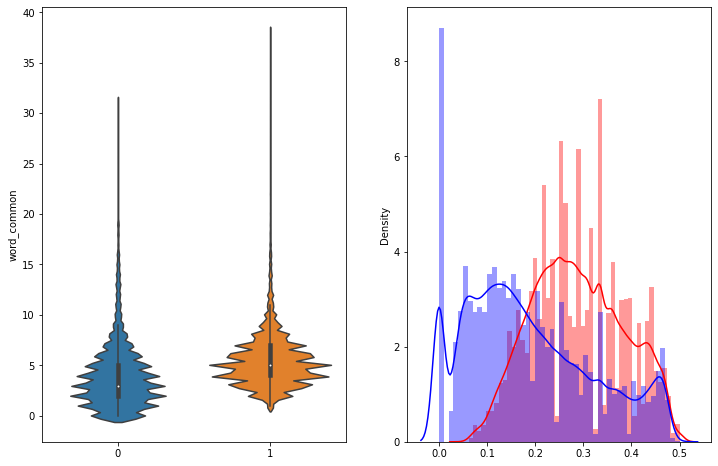

In [23]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = y_train, y = 'word_common', data = X_train)

plt.subplot(1,2,2)
sns.distplot(x , label = "1", color = 'red')
sns.distplot(y , label = "0" , color = 'blue' )
plt.show()

* In voilen plot we can see than when common words are less, there's a high probability that questions are dissimilar.
* PDF plot is highly overlapping, we can't conclude anything significant.

**Feature: word_share**

In [20]:
x, y = [], []
for i in range(len(X_train['word_share'])):
    if y_train[i]==1:
        x.append(X_train['word_share'].iloc[i])
    else:
        y.append(X_train['word_share'].iloc[i])

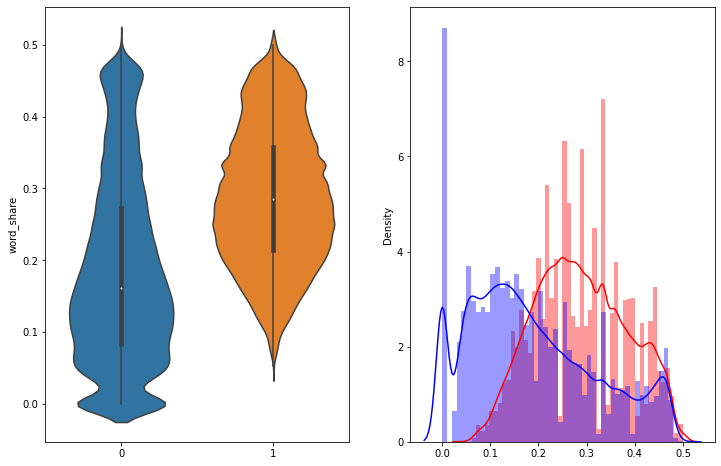

In [21]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = y_train, y = 'word_share', data = X_train)

plt.subplot(1,2,2)
sns.distplot(x , label = "1", color = 'red')
sns.distplot(y, label = "0" , color = 'blue' )
plt.show()

* As we can see, if the "word share" is low then the probability of questions being dissimilar is more, while if the "word share" is more chances of questions being similar is high.

## 6. Preprocessing of text

Preprocessing:
* Removing html tags
* Removing Punctuations
* Performing stemming
* Removing Stopwords
* Expanding contractions etc.

In [ ]:
stop_words = stopwords.words("english")

def preprocess_data(x):
    # Converting to lower case
    x = str().lower()
    
    
    
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)